In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
# 下面这个设定可以使notebook自动重载外部python 模块．]
# 也就是说，当从外部文件引入的函数被修改之后，在notebook中调用这个函数，得到的被改过的函数．
%load_ext autoreload
%autoreload 2
# 加载 CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'


X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


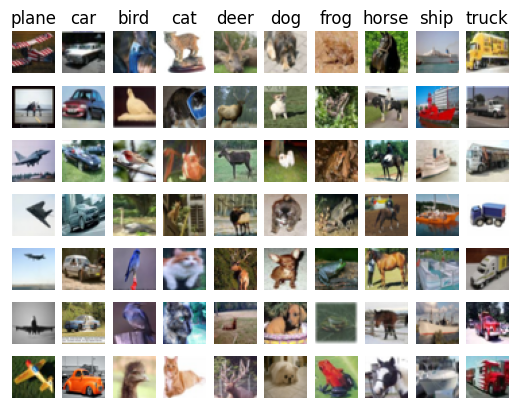

In [2]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [3]:
#将数据分割为训练集，验证集和测试集。
# 在分割之前首先从所有数据里面创建一个小的“开发集”作为训练集的子集，算法开发时可以使用这个开发集，使我们的代码运行更快。
# 此处的development set就是从训练集中进行了一个小的抽样，用来测试一些结论。

num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# 验证集将会是从原始的训练集中分割出来的长度为 num_validation 的数据样本点
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# 训练集是原始的训练集中前 num_train 个样本
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# 我们也可以从训练集中随机抽取一小部分的数据点作为开发集
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# 使用前 num_test 个测试集点作为测试集.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [4]:
# 数据预处理，将原始数据转成二维数据
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


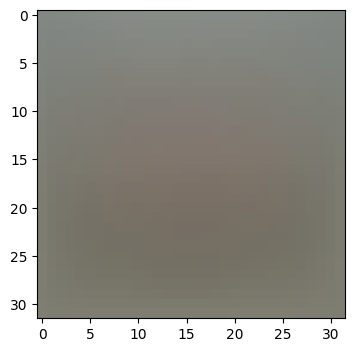

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [5]:
# 预处理，减去图像的平均值
# 首先，基于训练数据，计算图像的平均值
%matplotlib inline
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# 然后: 训练集和测试集图像分别减去均值#
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# t最后，在X中添加一列1作为偏置维度，这样我们在优化时候只要考虑一个权重矩阵W就可以啦
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [6]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# 生成一个很小的SVM随机权重矩阵
# 先标准正态随机然后乘0.0001
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.404524


In [6]:
print(grad)

[[-2.11694736e+01 -6.95093286e+00  1.32820233e+00 ... -1.26635004e+01
  -1.64505551e+01 -3.19881755e+01]
 [-2.76381369e+01 -6.49672143e+00  2.19713245e+00 ... -1.56086484e+01
  -2.93529680e+01 -3.63666210e+01]
 [-4.08843397e+01 -9.97317429e+00  1.03086171e+01 ... -1.00830700e+01
  -5.13346704e+01 -5.08758868e+01]
 ...
 [-4.61791984e+00 -9.23033714e+00 -7.33744147e+00 ... -9.97178498e+00
   1.55029148e+01 -2.88469339e+00]
 [-1.47907563e+01 -1.35159700e+01 -4.17677343e+00 ...  8.21843171e+00
  -1.64832886e+00 -5.46241457e+00]
 [ 1.02000000e-01  7.00000007e-02  6.19999999e-02 ...  7.39999996e-02
   1.66000000e-01 -3.40000008e-02]]


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [7]:
# 实现梯度之后，运行下面的代码重新计算梯度．
# 输出是grad_check_sparse函数的结果,2种情况下，可以看出，其实2种算法误差已经几乎不计了


# 对随机选的几个维度计算数值梯度，并把它和你计算的解析梯度比较．所有维度应该几乎相等
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# # 对随机选的几个维度计算数值梯度，并把它和你计算的解析梯度比较．所有维度应该几乎相等．
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# 再次验证梯度．这次使用正则项．
print('turn on reg')
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 13.374060 analytic: 13.374060, relative error: 2.370152e-11
numerical: -2.376302 analytic: -2.376302, relative error: 3.457989e-11
numerical: -8.489304 analytic: -8.489304, relative error: 3.151576e-11
numerical: 6.569327 analytic: 6.569327, relative error: 1.051099e-11
numerical: -21.985248 analytic: -21.985248, relative error: 1.715238e-11
numerical: -9.251943 analytic: -9.251943, relative error: 1.758282e-11
numerical: 9.750939 analytic: 9.750939, relative error: 4.798206e-11
numerical: -17.770149 analytic: -17.770149, relative error: 1.290372e-11
numerical: 18.700180 analytic: 18.700180, relative error: 1.724056e-11
numerical: -2.584297 analytic: -2.584297, relative error: 5.095278e-11
turn on reg
numerical: 12.772722 analytic: 12.771396, relative error: 5.193586e-05
numerical: -10.679133 analytic: -10.686576, relative error: 3.483662e-04
numerical: 6.368325 analytic: 6.366551, relative error: 1.392833e-04
numerical: -55.829397 analytic: -55.831827, relative error: 2.175

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  


In [8]:
# 完成 svm_loss_vectorized 方法，现在先计算loss,等一下再完成梯度
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.404524e+00 computed in 0.049011s
Vectorized loss: 8.404524e+00 computed in 0.436634s
difference: 0.000000


In [9]:
# # 使用向量来计算损失函数的梯度．
# 朴素方法和向量法的结果应该是一样的，但是向量法会更快一点．
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.048697s
Vectorized loss and gradient: computed in 0.000000s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [10]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 408.319428
iteration 100 / 1500: loss 243.542448
iteration 200 / 1500: loss 149.034613
iteration 300 / 1500: loss 91.324037
iteration 400 / 1500: loss 56.911429
iteration 500 / 1500: loss 36.782549
iteration 600 / 1500: loss 23.581254
iteration 700 / 1500: loss 16.185774
iteration 800 / 1500: loss 11.753191
iteration 900 / 1500: loss 9.205005
iteration 1000 / 1500: loss 7.351434
iteration 1100 / 1500: loss 6.758369
iteration 1200 / 1500: loss 5.807379
iteration 1300 / 1500: loss 5.527987
iteration 1400 / 1500: loss 5.146241
That took 4.520711s


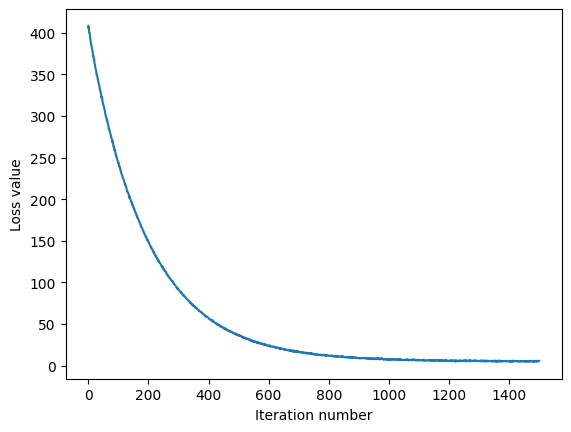

In [11]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [12]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.378204
validation accuracy: 0.371000


In [13]:
# 使用验证集去调整超参数（正则化强度和学习率），你要尝试各种不同的学习率
# 和正则化强度，如果你认真做，将会在验证集上得到一个分类准确度大约是0.4的结果。
# 设置学习率和正则化强度，多设几个靠谱的，可能会好一点。
# 可以尝试先用较大的步长搜索，再微调

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# 结果是一个词典，将形式为(learning_rate, regularization_strength) 的tuples 和形式为 (training_accuracy, validation_accuracy)的tuples 对应上。准确率就简单地定义为数据集中点被正确分类的比例。

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# 写下你的code ,通过验证集选择最佳超参数。对于每一个超参数的组合，
# 在训练集训练一个线性svm，在训练集和测试集上计算它的准确度，然后
# 在字典里存储这些值。另外，在 best_val 中存储最好的验证集准确度，
# 在best_svm中存储达到这个最佳值的svm对象。
#
# 提示：当你编写你的验证代码时，你应该使用较小的num_iters。这样SVM的训练模型
# 并不会花费太多的时间去训练。当你确认验证code可以正常运行之后，再用较大的
# num_iters 重跑验证代码。                               #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
# learning_rates = [2e-7, 0.75e-7,1.5e-7, 1.25e-7, 0.75e-7]
# regularization_strengths = [3e4, 3.25e4, 3.5e4, 3.75e4, 4e4,4.25e4, 4.5e4,4.75e4, 5e4]
np.random.seed(666)
lrs = 10 ** (np.random.rand(5)*1.2  - 7.5)
#rand(n)  随机取n个数，*1.5 - 7.5 是进行了一个缩放
regs = 10 ** (np.random.rand(8)* 2 + 3)

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for rate in lrs:
    for regular in regs:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=rate, reg=regular,
                      num_iters=1000)
        y_train_pred = svm.predict(X_train)
        accuracy_train = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        accuracy_val = np.mean(y_val == y_val_pred)
        results[(rate, regular)]=(accuracy_train, accuracy_val)
        if (best_val < accuracy_val):
            best_val = accuracy_val
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 2.050299e-07 reg 1.060245e+03 train accuracy: 0.326714 val accuracy: 0.322000
lr 2.050299e-07 reg 1.252061e+03 train accuracy: 0.326755 val accuracy: 0.333000
lr 2.050299e-07 reg 1.584372e+03 train accuracy: 0.334286 val accuracy: 0.356000
lr 2.050299e-07 reg 2.430995e+03 train accuracy: 0.338265 val accuracy: 0.332000
lr 2.050299e-07 reg 2.514752e+03 train accuracy: 0.342245 val accuracy: 0.349000
lr 2.050299e-07 reg 6.717001e+03 train accuracy: 0.376612 val accuracy: 0.383000
lr 2.050299e-07 reg 1.037845e+04 train accuracy: 0.370245 val accuracy: 0.385000
lr 2.050299e-07 reg 3.078282e+04 train accuracy: 0.363061 val accuracy: 0.378000
lr 2.190406e-07 reg 1.060245e+03 train accuracy: 0.324490 val accuracy: 0.301000
lr 2.190406e-07 reg 1.252061e+03 train accuracy: 0.327612 val accuracy: 0.334000
lr 2.190406e-07 reg 1.584372e+03 train accuracy: 0.329367 val accuracy: 0.331000
lr 2.190406e-07 reg 2.430995e+03 train accuracy: 0.343429 val accuracy: 0.341000
lr 2.190406e-07 reg 2.514752

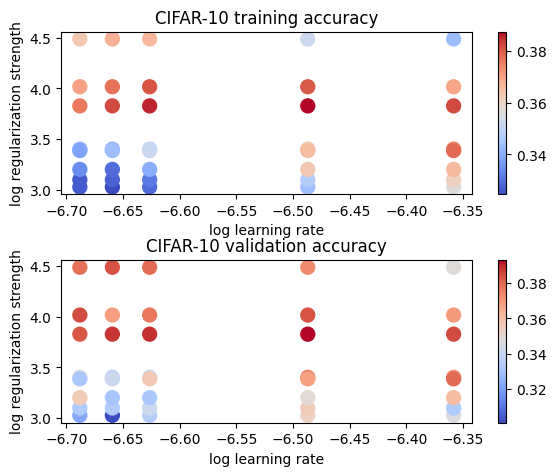

In [14]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [15]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.379000


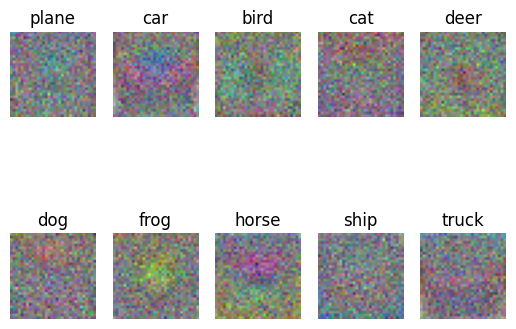

In [16]:
# 对于每一类，可视化学习到的权重
#依赖于你对学习权重和正则化强度的选择，这些可视化效果或者很明显或者不明显
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
